In [46]:
import librosa
import librosa.display
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pylab
from scipy import signal
from tqdm.notebook import tqdm
from glob import glob
import gc

import tensorflow as tf
import keras
from keras import layers, losses
from keras.models import Model, load_model
import keras.backend as K

from keras.losses import binary_crossentropy, mean_squared_error

from keras.layers import Input,Conv2D, Layer, UpSampling2D, MaxPooling2D, Dense, Flatten, Lambda, GlobalAveragePooling2D, Conv2DTranspose, Reshape, BatchNormalization, Dropout, ELU, ReLU
from tensorflow.keras.utils import plot_model

## Getting the DataSet

In [47]:
train_paths = glob('D:/Projects/Orpheus_ai/DataSet/Spectrograms/MEL_dbscale/*')[:-100]
test_paths = glob('D:/Projects/Orpheus_ai/DataSet/Spectrograms/MEL_dbscale/*')[-100:]

BATCH_SIZE = 4
AUTOTUNE = tf.data.experimental.AUTOTUNE
min_level_db = -80 

In [48]:
def data_loader(path):
    path = bytes.decode(path.numpy())
    spec = tf.cast(np.load(path),tf.float32)
    spec = tf.expand_dims(spec,axis=-1)
    return spec

def normalize(S):
    return np.clip((((S - min_level_db) / -min_level_db)*2.)-1., -1, 1)

def denormalize(S):
    return (((np.clip(S, -1, 1)+1.)/2.) * -min_level_db) + min_level_db


In [49]:
def get_dataset(data_paths):
    dataset = tf.data.Dataset.from_tensor_slices(data_paths)
    dataset = dataset.map(lambda x : tf.py_function(data_loader, [x], [tf.float32]), num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(lambda x : tf.py_function(normalize, [x], [tf.float32]), num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [50]:
X_train = get_dataset(train_paths)
X_test = get_dataset(test_paths)

In [51]:
# # ## Direct
# dataframe = pd.read_pickle('D:/Projects/Orpheus_ai/DataSet/inst_spectrogram.pkl')
# X = dataframe['stft_logscale']
# var = np.var(np.concatenate(X.apply(lambda a: np.expand_dims(a,0)).values,axis=0))
# del(X)
# del(dataframe)
# gc.collect()
# # X_train = X.sample(n=100).sort_index()
# # X_test = X[~X.index.isin(X_train.index)]
# # X_train, X_test = np.concatenate(X_train.apply(lambda a: np.expand_dims(a,0)).values,axis=0), np.concatenate(X_test.apply(lambda a: np.expand_dims(a,0)).values,axis=0)

# # X_train, X_test = tf.expand_dims(X_train,axis=-1), tf.expand_dims(X_train,axis=-1)

## Model Architecture

In [53]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = (
            beta  # This parameter is best kept between [0.25, 2] as per the paper.
        )

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = self.beta * tf.reduce_mean(
            (tf.stop_gradient(quantized) - x) ** 2
        )
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices
    
    def get_config(self):

        config = super().get_config().copy()
        return config
    
class VQVAETrainer(keras.models.Model):
    
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae,self.encoder,self.decoder = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")
        
    def call(self, inputs, training=False):
        ## Dummy call to just save this
        x = inputs
        x = self.vqvae(x)
        return x

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = tf.reduce_mean((x - reconstructions) ** 2)
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }
    
    
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(128, 431, 1))
    x = layers.SeparableConv2D(256, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.SeparableConv2D(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.SeparableConv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.SeparableConv2D(32, 3, activation="relu", strides=2, padding="same")(x)
    
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder().output.shape[1:])
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    decoder_outputs = layers.Resizing(128, 431)(decoder_outputs)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

    
def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(128, 431, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae"), keras.Model(inputs, encoder_outputs, name="vq_enc"), decoder

In [54]:
vqvae= VQVAETrainer(var, latent_dim=16, num_embeddings=128)
vqvae._set_inputs(tf.ones((1, 128, 431, 1)))

In [55]:
model_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='reconstruction_loss', patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='D:/Projects/Orpheus_ai/DataSet/model_save_logs/VQVAE/model.{epoch:02d}-{loss:.5f}',monitor='reconstruction_loss',save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='D:/Projects/Orpheus_ai/DataSet/model_save_logs/VQVAE/tfboard_logs'),
]

In [ ]:
vqvae.compile(optimizer='adam')
history = vqvae.fit(X_train, epochs=300, callbacks=model_callbacks,
          steps_per_epoch=np.ceil(len(train_paths)/BATCH_SIZE),)

Epoch 1/300
4192/6220 [===================>..........] - ETA: 2:17 - loss: 0.0842 - reconstruction_loss: 0.0416 - vqvae_loss: 0.0189

In [13]:
# import plotly.express as px
# px.line(pd.DataFrame(history.history))

### Rough Test

In [11]:
import librosa
import librosa.display
import IPython.display as ipd

sr = 22050
hop_length = 512
n_fft = 1024

song_info = pd.read_csv('D:/Projects/Orpheus_ai/DataSet/main_dataframe.csv')

In [12]:
test_dataset = next(iter(X_train))[0]
model_output = model.predict(test_dataset)

In [13]:
index = 15

## Original
S = test_dataset.numpy()[index,:,:,0]
S = denormalize(S)

## Original
S_hat = model_output[index,:,:,0]
S_hat = denormalize(S)

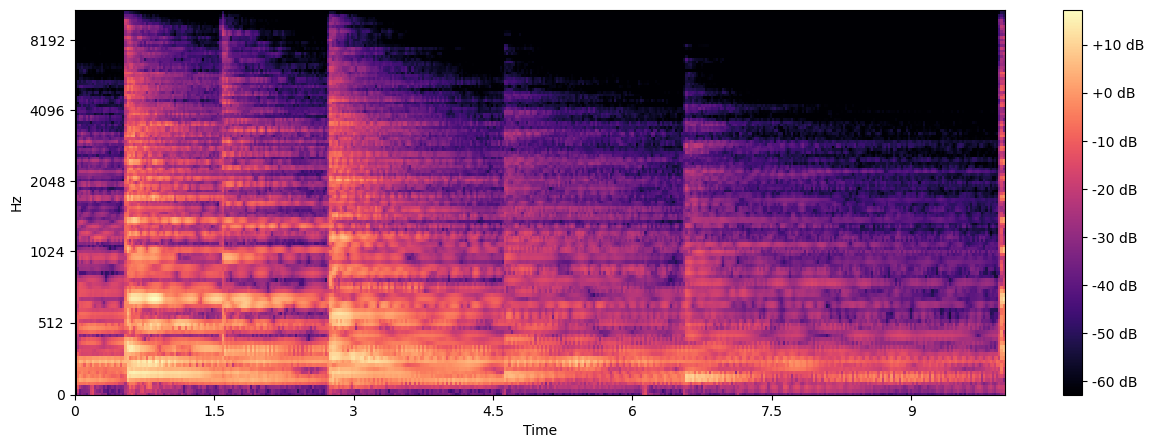

In [14]:
## Original
plt.figure(figsize=(15, 5))
librosa.display.specshow(S, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel',cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.show()

## Recreated
plt.figure(figsize=(15, 5))
librosa.display.specshow(S_hat, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel',cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [15]:
output = librosa.feature.inverse.mel_to_audio(librosa.db_to_power(S),sr=sr,n_fft=n_fft,hop_length=hop_length)
ipd.Audio(output, rate=sr)

In [16]:
output = librosa.feature.inverse.mel_to_audio(librosa.db_to_power(S_hat),sr=sr,n_fft=n_fft,hop_length=hop_length)
ipd.Audio(output, rate=sr)

1/1 [==============================] - 0s 355ms/step
